# House Price Challenge
This is an assignment for my thinkful data science course. 
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/House_Challenge.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/House_Challenge.ipynb) - with all the code exposed in an interactive notebook


## House prices dataset

I'm demonstrating a linear regression modeling on a house prices dataset originally from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The target variable will be the "SalePrice" (the property's sale price in dollars). Since it's a continuous variable, we're dealing with a regression task.

This overview is presented in 4 parts: 

1. Dataset overview and cleaning
2. Feature selection
3. Model fit and evaluation
4. Impact of adding economic metrics as explanatory variables


### Dataset Overview & Cleaning

In [1]:
#imports & connection
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML


import warnings
warnings.filterwarnings('ignore')

In [2]:
#db connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
#data load
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [4]:
#reset index, head of raw data
houses_df.set_index("id")
houses_df.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
houses_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
houses_df.describe(include="O")

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


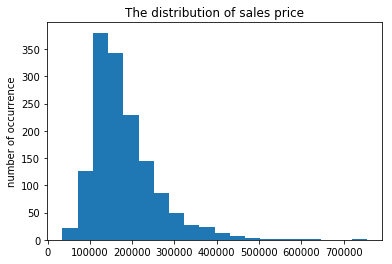

In [7]:
# target variable distribution
plt.hist(houses_df.saleprice, bins=20)
plt.title("The distribution of sales price")
plt.ylabel("number of occurrence")
plt.show()

We observe that sales price is not quite normally distributed. Instead, it's highly skewed. **Skewness** is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the sales price variable is not symmetric but skewed to the right. The majority of the observations have low prices and few of the observations have high prices. This makes the distribution of the charges clustered toward the left.

In [8]:
#look for missing values and drop those columns
#there are plenty of powerful variables without missing values, so I will not spend energy investigating 
#variables with missing values. 

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]
    
houses_df = remove_null_cols(houses_df)

### Feature Selection

In [9]:
#get all the continuous and categorical columns
#thus far I'm just exploring the categorical columns.  Eventually I would like to explore the continuous.

from itertools import compress

cont_cols = list(compress(houses_df.columns, houses_df.dtypes == int))
cat_cols = list(compress(houses_df.columns, houses_df.dtypes == object))

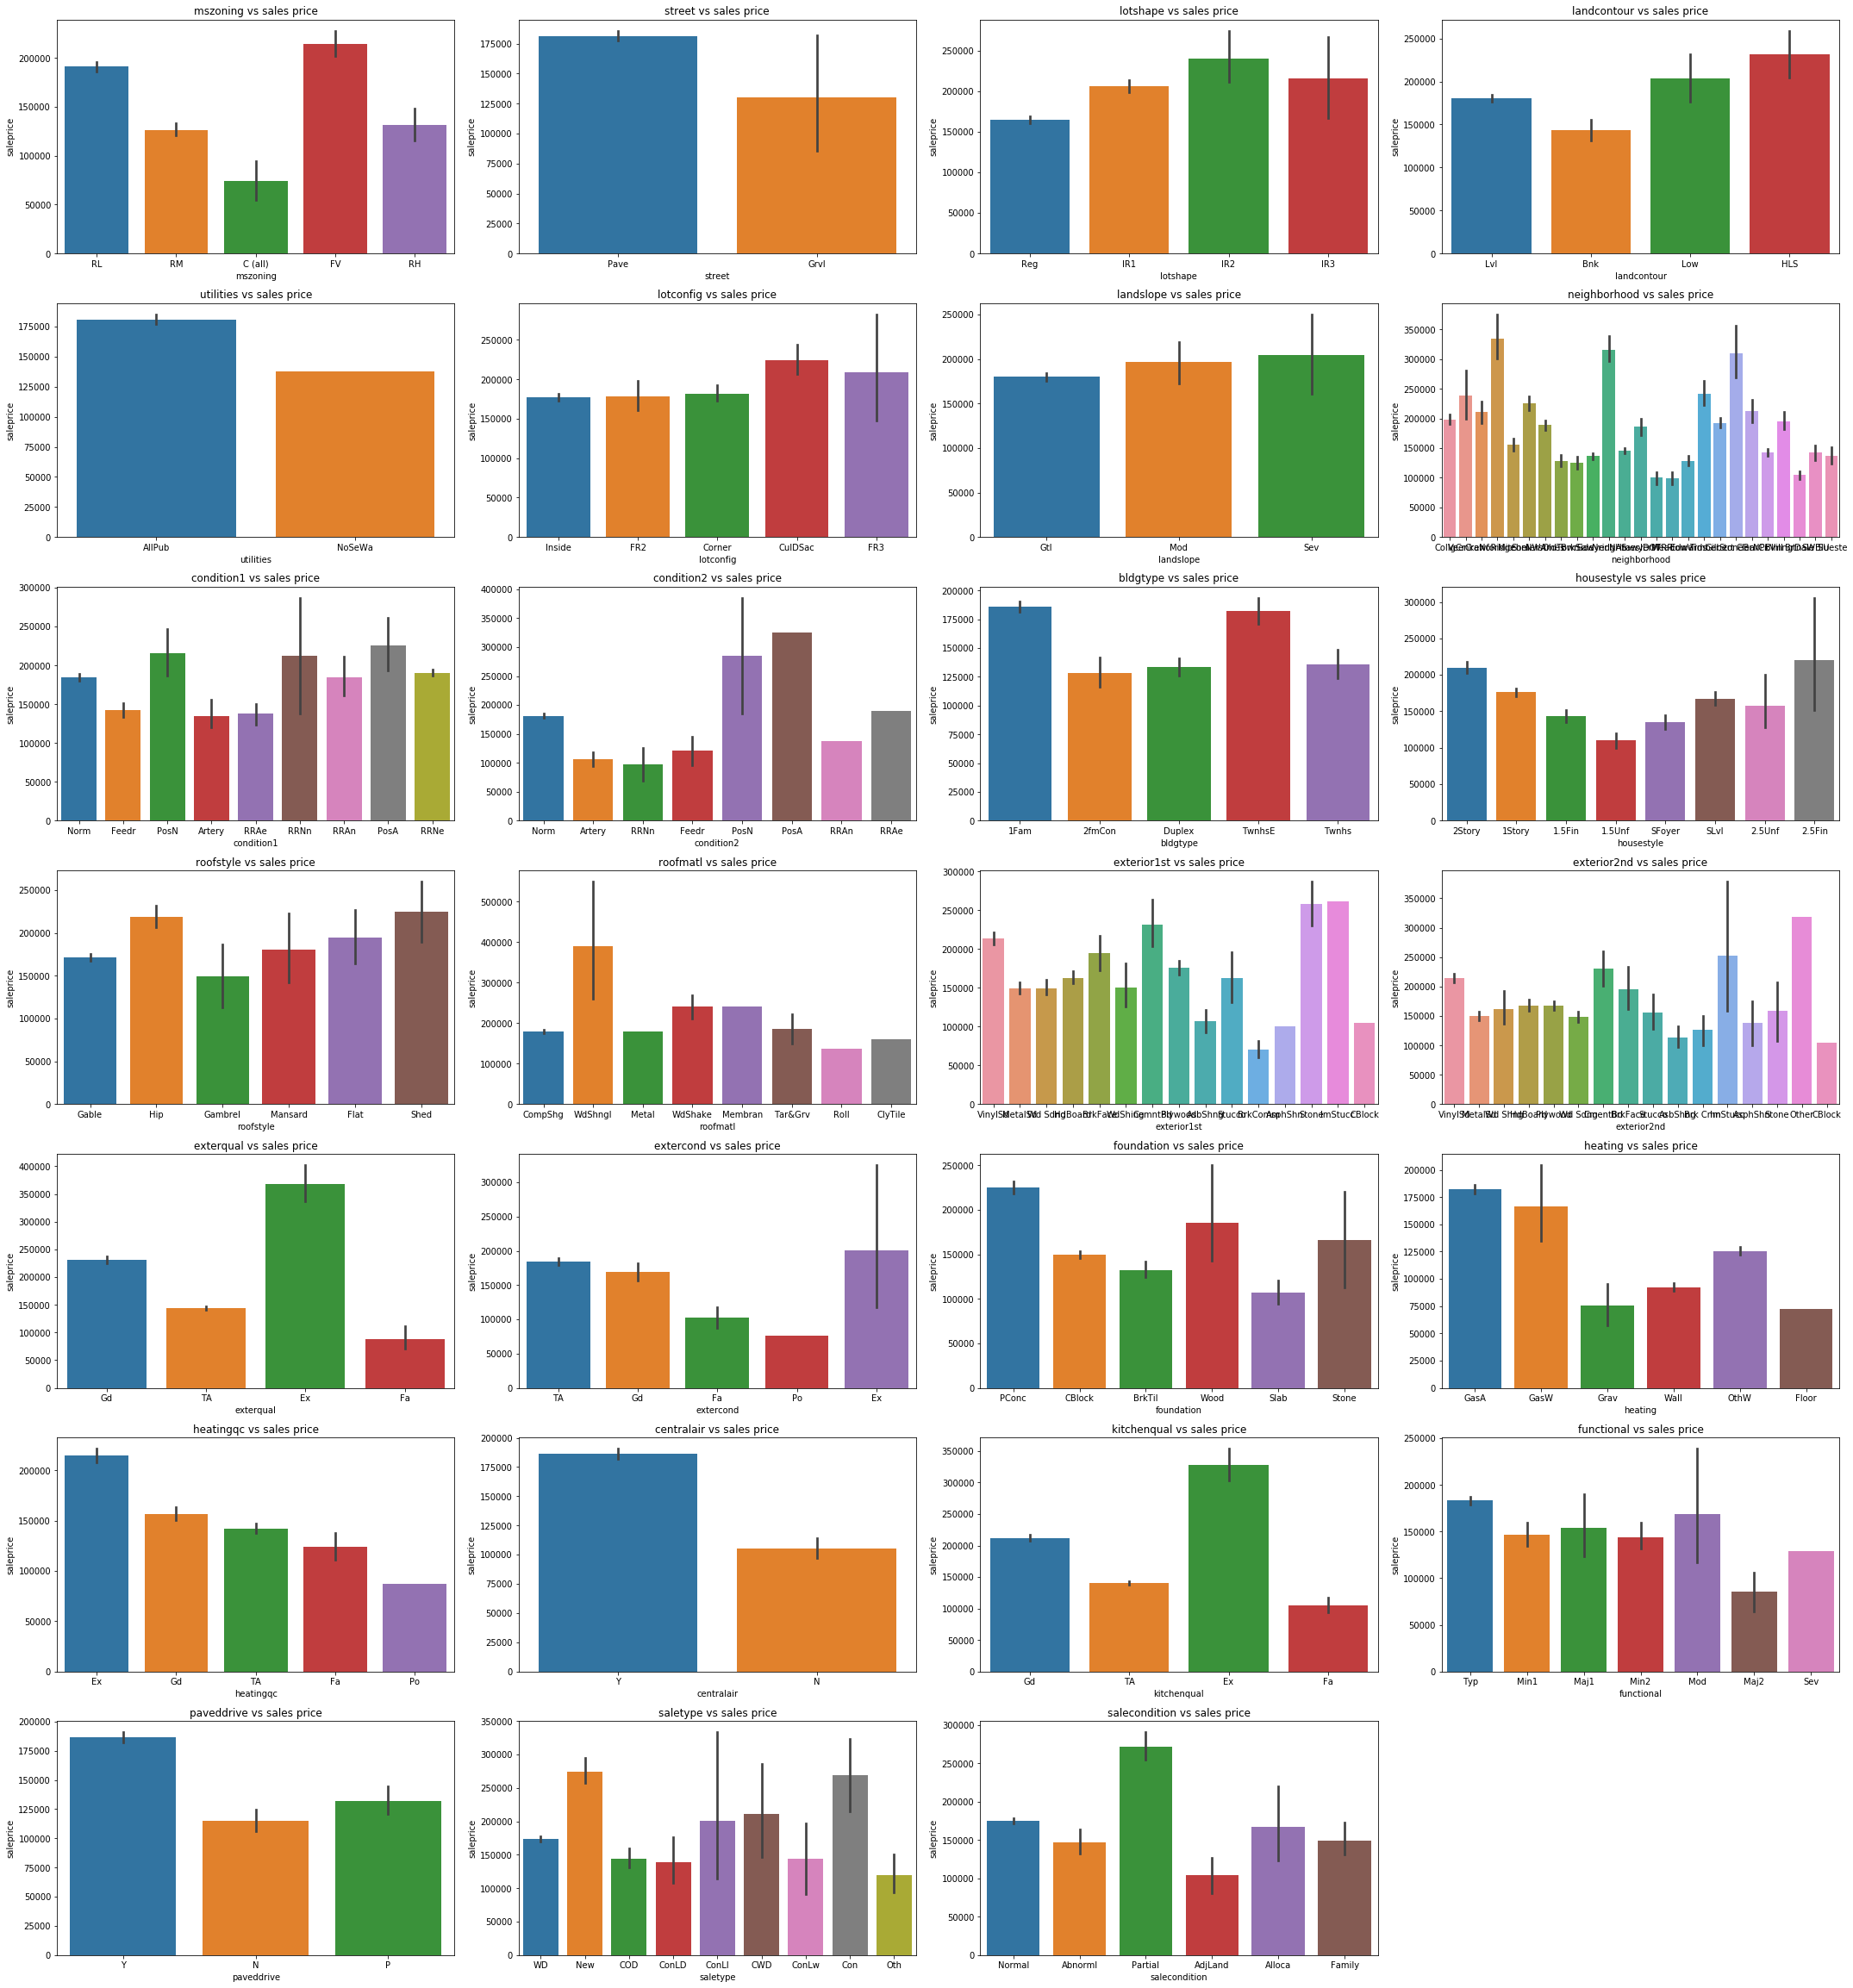

In [13]:
#for catgorical variables - get a visual on which variables split house price
#I'm choosing potential categorical variables only on visual inspection, 
#but I would like to do this algorithmically in the future.  

def cat_to_cont(df, cat, cont, threshold):
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()
    sns.barplot(df[cat], df[cont])

plt.figure(figsize=(30,50))
for index, cat in enumerate(cat_cols): 
    plt.subplot(11,4,index+1)
    cat_to_cont(houses_df, cat, "saleprice", .05)
    plt.title("{} vs sales price".format(cat))

plt.tight_layout()
plt.show()

In [14]:
#transform the promising categorical variables to one-hot columns and create a features dataframe
neighborhood_df = pd.get_dummies(houses_df.neighborhood, prefix='neighborhood', drop_first=True)
mszoning_df = pd.get_dummies(houses_df.mszoning, prefix='mszoning', drop_first=True)
exterqual_df = pd.get_dummies(houses_df.exterqual, prefix='exterqual', drop_first=True)
kitchenqual_df = pd.get_dummies(houses_df.kitchenqual, prefix='kitchenqual', drop_first=True)
heatingqc_df = pd.get_dummies(houses_df.heatingqc, prefix='heatingqc', drop_first=True)
salecondition_df = pd.get_dummies(houses_df.salecondition, prefix='salecondition', drop_first=True)

features = pd.concat([neighborhood_df, mszoning_df, exterqual_df, 
                      kitchenqual_df, heatingqc_df, salecondition_df], 
                    axis=1)


In [15]:
#find some powerful continuous variables and list our full feature set

#take the 5 with the highest correlation with sales price 
cont_corrs = np.abs(houses_df[cont_cols].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)
top_cont = cont_corrs.head(10)[1:6].index.values

#add the new columns to the features dataframe
for cont in top_cont: 
    features[cont] = houses_df[cont]

print(features.columns)

Index(['neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide',
       'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR',
       'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes',
       'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU',
       'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker',
       'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM',
       'exterqual_Fa', 'exterqual_Gd', 'exterqual_TA', 'kitchenqual_Fa',
       'kitchenqual_Gd', 'kitchenqual_TA', 'heatingqc_Fa', 'heatingqc_Gd',
       'heatingqc_Po', 'heatingqc_TA', 'salecondition_AdjLand',
       'salecondition_Alloca', 'salecondition_Family', 'salecondition_Normal',
       'saleconditi

## Model Fit and Evaluation

Here's four models, all using all of our chosen features, all trained and evaluated on 80% training & 20% hold out data respectively, and each using a different loss function: LRM, Lasso, Ridge and Elastinet. 

The Ridge loss function is slightly better than the others at prediction. 

In [16]:
#Model CV implementations, predictions and evaluations for lasso, ridge and elasticnet

Y = houses_df['saleprice']
X = features

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
l1_ratio=[.1, .5, .7, .9, .95, .99, 1]

lrm = LinearRegression()
lrm.fit(X_train, y_train)

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5, l1_ratio=l1_ratio)
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here

def predict_and_evaluate(models, model_names, X_train, y_train, X_test):
    
    i = 0
    best_alpha = []
    r_squared_train = []
    r_squared_test = []
    mean_abs_err = []
    mean_sq_err = []
    rt_mean_sq_err = []
    mean_abs_perc_err = []
        
    for model in models: 
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
        
        if (getattr(model, "alpha_", False)):
            best_alpha.append(model.alpha_)
        else: 
            best_alpha.append(None)
        r_squared_train.append(model.score(X_train, y_train))
        r_squared_test.append(model.score(X_test, y_test))
        mean_abs_err.append(mean_absolute_error(y_test, y_preds_test))
        mean_sq_err.append(mse(y_test, y_preds_test))
        rt_mean_sq_err.append(rmse(y_test, y_preds_test))
        mean_abs_perc_err.append(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)
        i += 1
    summary = pd.DataFrame({"best_alpha": best_alpha, "r_squared_train": r_squared_train, 
                        "r_squared_test": r_squared_test, "mean_abs_err": mean_abs_err, 
                        "mean_sq_err": mean_sq_err, "rt_mean_sq_err": rt_mean_sq_err,
                        "mean_abs_perc_err": mean_abs_perc_err})
    summary.index = model_names
    return summary
        
summ_results = predict_and_evaluate([lrm, lasso_cv, ridge_cv, elasticnet_cv],["lrm", "lasso_cv", "ridge_cv", "elasticnet_cv"], X_train, y_train, X_test)
summ_results

,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
lrm,NaN,0.836776,0.812643,22907.335622,1.257858e+09,35466.291184,12.792818
lasso_cv,100.0,0.833036,0.808366,23043.166742,1.286573e+09,35868.826412,12.992106
ridge_cv,1.0,0.836153,0.813426,22781.683584,1.252601e+09,35392.101041,12.776246
elasticnet_cv,100.0,0.833036,0.808366,23043.166742,1.286573e+09,35868.826412,12.992106


### 4. Impact of adding economic metrics as explanatory variables
There's a downward trend in sales price during this period.  There was of course "great recession" that began in mid-2007, which had a dramatic effect on real estate prices nationally.  We could capture some of that information with economic indicators.  Let's take a look at a few:  30 year mortgate rates, the s&p 500 index adjusted close, and UCM's consumer sentiment index. 

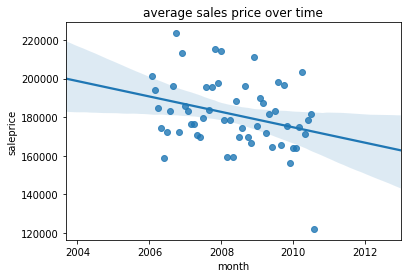

In [17]:
#demonstrate downward trend in saleprice in this period
df = houses_df.loc[:,["yrsold", "mosold", "saleprice"]].groupby(by=["yrsold","mosold"]).mean()
df['x'] = df.index.get_level_values(0) + df.index.get_level_values(1)/12
df.reset_index(inplace=True)
sns.regplot(x="x", y="saleprice", data=df, fit_reg=True)
plt.xlabel("month")
plt.title("average sales price over time")
plt.show()

In [18]:
#create a dataframe of monthly values for these 3 indicators. 

import datetime

def index_col(df, col): 
    base = df[col][0]
    return df[col]/base

#from https://fred.stlouisfed.org/series/MORTGAGE30US
mtg = pd.read_csv("MORTGAGE30US.CSV")
#from https://yahoo.com
sandp = pd.read_csv("monthlysandp.CSV")
#from https://fred.stlouisfed.org/series/UMCSENT
sent = pd.read_csv("UMCSENT.CSV")
sandp.rename(columns={'Date':'DATE'}, inplace=True)

#all input dataframes must have '%Y-%m-%d' date column named 'DATE'
def make_monthly_ave(df): 
    dates = df.DATE.values
    df["YEAR"] = [datetime.datetime.strptime(d, '%Y-%m-%d').year for d in dates] 
    df["MONTH"] = [datetime.datetime.strptime(d, '%Y-%m-%d').month for d in dates]
    return df.groupby(["YEAR", "MONTH"]).mean()
    

mtg_df = make_monthly_ave(mtg)
sandp_df = make_monthly_ave(sandp)
sent_df = make_monthly_ave(sent)

combined = mtg_df.join([sandp_df, sent_df]).reset_index()
combined = combined.loc[(combined.YEAR >= 2006) & (combined.YEAR <= 2010), :].reset_index(drop=True)
combined = combined.loc[:,["YEAR", "MONTH", "MORTGAGE30US","Adj Close", "UMCSENT"]]
for col in ["MORTGAGE30US","Adj Close", "UMCSENT"]:
    combined[col] = index_col(combined, col)

Text(0.5, 1.0, 'economic indicators indexed by Jan 2016 value')

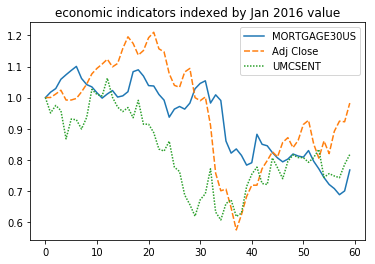

In [19]:
#graph the three indicators
combined['x'] = combined.YEAR + combined.MONTH/12
# sns.relplot(x="x", y="MORTGAGE30US", data=combined, kind="line")
# sns.relplot(x="x", y="Adj Close", data=combined, kind="line")
# sns.relplot(x="x", y="UMCSENT", data=combined, kind="line")
sns.lineplot(data=combined[["MORTGAGE30US", "Adj Close", "UMCSENT"]])
plt.title("economic indicators indexed by Jan 2016 value")

All of these indicators have a similar downward trend.  I could use any of them to attempt to get at the recession malaise.  

The first three, one-row tables below each shows the prediction performance of a model that adds one of the three economic metrics.  I've used the ridge loss algorithm since that had marginally better predictive power on the base feature set compared to lrm, lasso and elasticnet.  The last table is a reprint of the model that has none of these economic metrics.  

As you can see, the economic features added little prediction power.  I would leave them out of the model for the sake of simplicity. 

In [20]:
#build and evaluate 3 new models, each with one of the economic metrics

sandp_dict = {(int(m), int(y)): r for (m,y,r) in combined.loc[:, ["MONTH", "YEAR", "Adj Close"]].values}
mtg_dict = {(int(m), int(y)): r for (m,y,r) in combined.loc[:, ["MONTH", "YEAR", "MORTGAGE30US"]].values}
UMCSENT_dict = {(int(m), int(y)): r for (m,y,r) in combined.loc[:, ["MONTH", "YEAR", "UMCSENT"]].values}

mtg_feature = [mtg_dict.get((row.mosold, row.yrsold)) for row in houses_df.itertuples()]
sandp_feature = [sandp_dict.get((row.mosold, row.yrsold)) for row in houses_df.itertuples()]
UMCSENT_feature = [UMCSENT_dict.get((row.mosold, row.yrsold)) for row in houses_df.itertuples()]

Y = houses_df['saleprice']
X_mtg = features.copy()
X_sandp = features.copy()
X_UMCSENT = features.copy()
X_mtg["mtg_rate"] = mtg_feature
X_sandp["sandp_close"] = sandp_feature
X_UMCSENT["UMC_Sentiment"] = UMCSENT_feature

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

X_train, X_test, y_train, y_test = train_test_split(X_mtg, Y, test_size = 0.2, random_state = 465)
ridge_mtg = RidgeCV(alphas=alphas, cv=5)
ridge_mtg.fit(X_train, y_train)
display(predict_and_evaluate([ridge_mtg],["ridge_mtg"], X_train, y_train, X_test))

X_train, X_test, y_train, y_test = train_test_split(X_sandp, Y, test_size = 0.2, random_state = 465)
ridge_sandp = RidgeCV(alphas=alphas, cv=5)
ridge_sandp.fit(X_train, y_train)
display(predict_and_evaluate([ridge_sandp],["ridge_sandp"], X_train, y_train, X_test))

X_train, X_test, y_train, y_test = train_test_split(X_UMCSENT, Y, test_size = 0.2, random_state = 465)
ridge_UMCSENT = RidgeCV(alphas=alphas, cv=5)
ridge_UMCSENT.fit(X_train, y_train)
display(predict_and_evaluate([ridge_UMCSENT],["ridge_UMCSENT"], X_train, y_train, X_test))

display(summ_results)

,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
ridge_mtg,1.0,0.836175,0.81365,22778.64098,1.251101e+09,35370.908767,12.771385


,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
ridge_sandp,1.0,0.836159,0.81353,22779.714933,1.251907e+09,35382.300135,12.775785


,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
ridge_UMCSENT,1.0,0.836161,0.813286,22788.770711,1.253541e+09,35405.38366,12.782761


,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
lrm,NaN,0.836776,0.812643,22907.335622,1.257858e+09,35466.291184,12.792818
lasso_cv,100.0,0.833036,0.808366,23043.166742,1.286573e+09,35868.826412,12.992106
ridge_cv,1.0,0.836153,0.813426,22781.683584,1.252601e+09,35392.101041,12.776246
elasticnet_cv,100.0,0.833036,0.808366,23043.166742,1.286573e+09,35868.826412,12.992106
